In [14]:
import numpy as np
import scipy.fftpack as fft
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import urllib.request as urlr
import scipy.optimize as opt
from scipy.signal import savgol_filter
import time, os
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
# plt.switch_backend("TkAgg")
plt.style.use("seaborn")
plt.rcParams["font.family"] = "serif"
plt.rcParams["text.usetex"] = True
plt.rcParams["figure.figsize"] = (5*16/9, 5)

In [3]:
class PressureSensor:
    
    def __init__(self, url, calibration):
        m, Vraw = np.genfromtxt(calibration, unpack=True)
        m *= 1e-3
        F = m*9.81
        Vin = Vraw/1024 * 3.3
        
        def f(t, a, b):
            return a*np.exp(-b*t)

        popt, pcov = opt.curve_fit(f, F, Vin)
        
        self.popt = popt
        self.url = url
        self.F = F
        self.Vin = Vin
        self.f = f
        self.count = 0
        self.Fin = []
        self.t = []
        self.t0 = time.time()
        
    def plot_calibration(self):
        x = np.linspace(self.F.min(), self.F.max(), 100)
        plt.plot(self.F, self.Vin, "o")
        plt.plot(x, self.f(x, *self.popt), label=r"$y = %.2f\exp(-%.2fx)$"%(tuple(self.popt)))
        plt.xlabel("force [N]")
        plt.ylabel("voltage [V]")
        plt.legend()
        plt.show()
        
    def get_data(self):
        y = urlr.urlopen(self.url).read()
        y = y.decode("utf-8")
        y = float(y)/1024 * 3.3
#         x = np.log(y/self.popt[0])/(-self.popt[1])
        return y

    def continue_loop(self):
        while True:
            self.count += 1
            yield self.count

    def update(self, continue_loop):
        self.Fin.append(self.get_data())
        self.t.append(time.time() - self.t0)
        self.line.set_xdata(self.t)
        self.line.set_ydata(self.Fin)
        
#         if (np.round(self.t[-1]).astype(int))%3 == 0:
#             out = abs(fft.fft(self.Fin[-100:]))
#             dt = self.t[-1] - self.t[-2]
#             freq = abs(fft.fftfreq(np.array(self.t[-100:]).shape[-1]))*100
#             df = np.argmax(out)/dt/len(out)

#             if df >= 1.5 and df <= 2.5:
#                 self.mtype = "walking"
#             elif df > 2.5:
#                 self.mtype = "running"
#             else:
#                 self.mtype = "standing"
        
#             self.data_sttext.set_text(self.data_step % (self.mtype, df))
            
        if self.Fin[-1] > max(self.Fin[-100:])/2:
            step_status = "off"
        else:
            step_status = "on"
        
        self.data_swtext.set_text(self.data_switch % (step_status))
        self.ax.relim(True)
        self.ax.autoscale_view(True, True, True)
        
        if (np.round(self.t[-1]).astype(int))%2 == 0:
            dat = np.array([self.t, self.Fin])
            np.save("datalog.npy", dat)
            
        return self.line
    
    def runlive(self):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111)
        self.ax.set_xlabel("time [s]")
        self.ax.set_ylabel("voltage [V]")
        
        self.Fin.append(self.get_data())
        self.t.append(time.time() - self.t0)
        self.line, = self.ax.plot(self.t, self.Fin)
        
#         self.data_step = r"%s \\ %.2f steps per second"
        self.data_switch = r"foot %s"
#         self.data_sttext = self.ax.text(0, 0.8, "", transform=self.ax.transAxes, fontsize=12)
        self.data_swtext = self.ax.text(0, 0.99, "", transform=self.ax.transAxes, fontsize=12)
        
        ani = anim.FuncAnimation(self.fig, self.update, self.continue_loop)
        plt.show(block=True)
        

def characterization(filename, width, polyorder, lim=[0,-1], save=False):
    if not filename.endswith(".npy"):
        t, motion = np.genfromtxt(filename, skip_header=2, delimiter=",", unpack=True)
        t = t/1000
    else:
        t, motion = np.load(filename)
    t -= t.min()
    yfilt = savgol_filter(motion, width, polyorder)
    fig = plt.figure(figsize=(5*16/9*2, 5))

    ax = fig.add_subplot(121)
    ax.plot(t[lim[0]:lim[1]], motion[lim[0]:lim[1]], 'r--', alpha = 0.25)
    ax.plot(t[lim[0]:lim[1]], yfilt[lim[0]:lim[1]], 'k-', lw = 2)
    ax.set_xlabel("time [s]")
    ax.set_ylabel("voltage [V]")

    ax = fig.add_subplot(122)
    out = np.abs(fft.fft(yfilt))
    freq = np.abs(fft.fftfreq(t.shape[-1]))*10
    ax.plot(freq[lim[0]:lim[1]], out[lim[0]:lim[1]], 'b--')
    ax.plot(freq[lim[0]:lim[1]], out[lim[0]:lim[1]], 'ro')
    ax.set_xlabel("frequency [Hz]")
    ax.set_ylabel("frequency density")

    plt.suptitle(filename[:-4])
    
    if save:
        plt.savefig(filename[:-4] + ".png", dpi=300, bbox_inches="tight")
        
    plt.show()

In [74]:
url = "http://192.168.42.103"
ps = PressureSensor(url, "calibration.txt")
ps.plot_calibration()
ps.runlive()

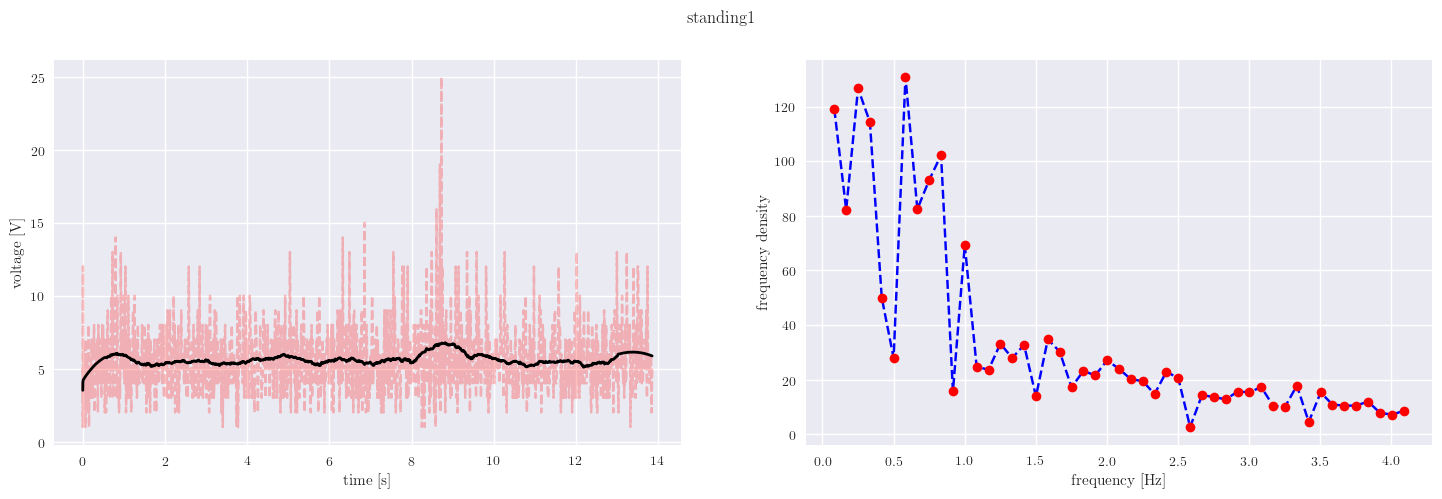

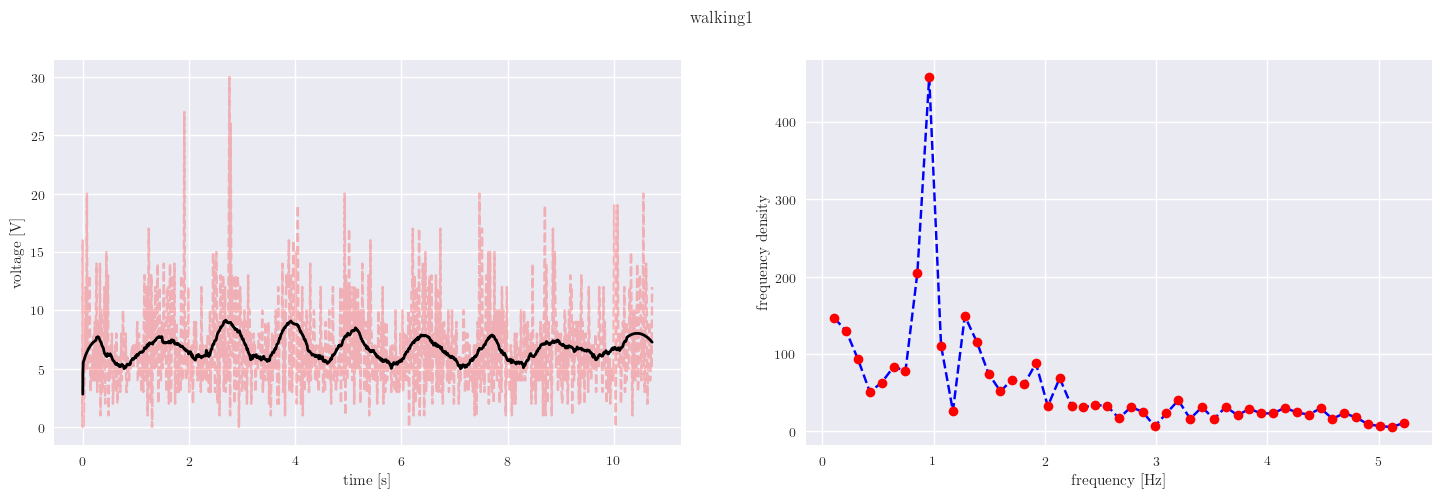

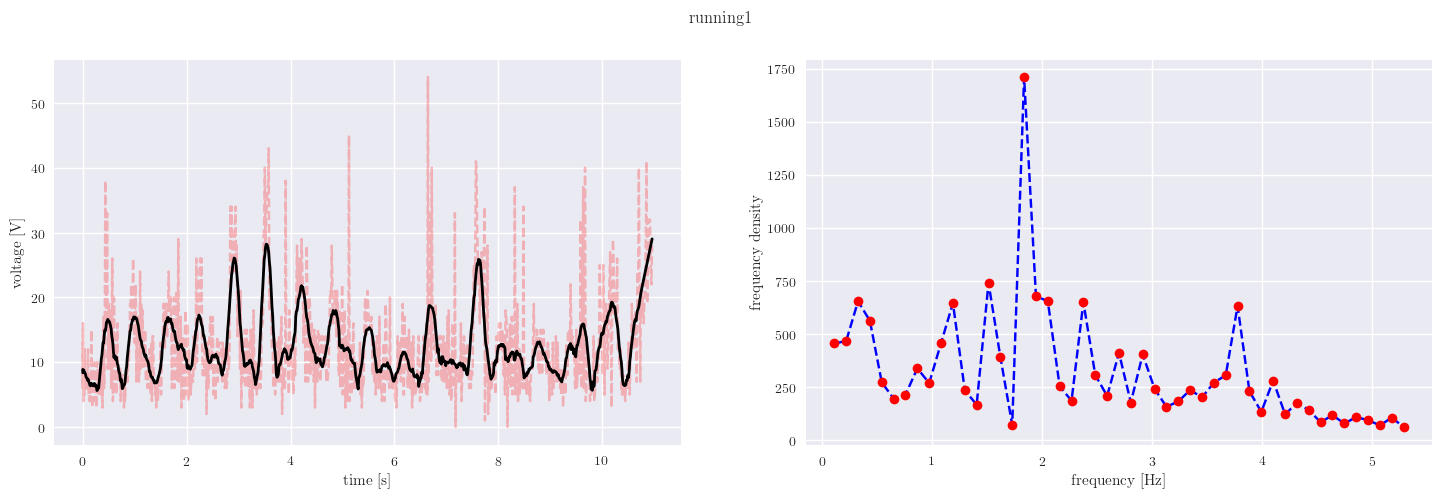

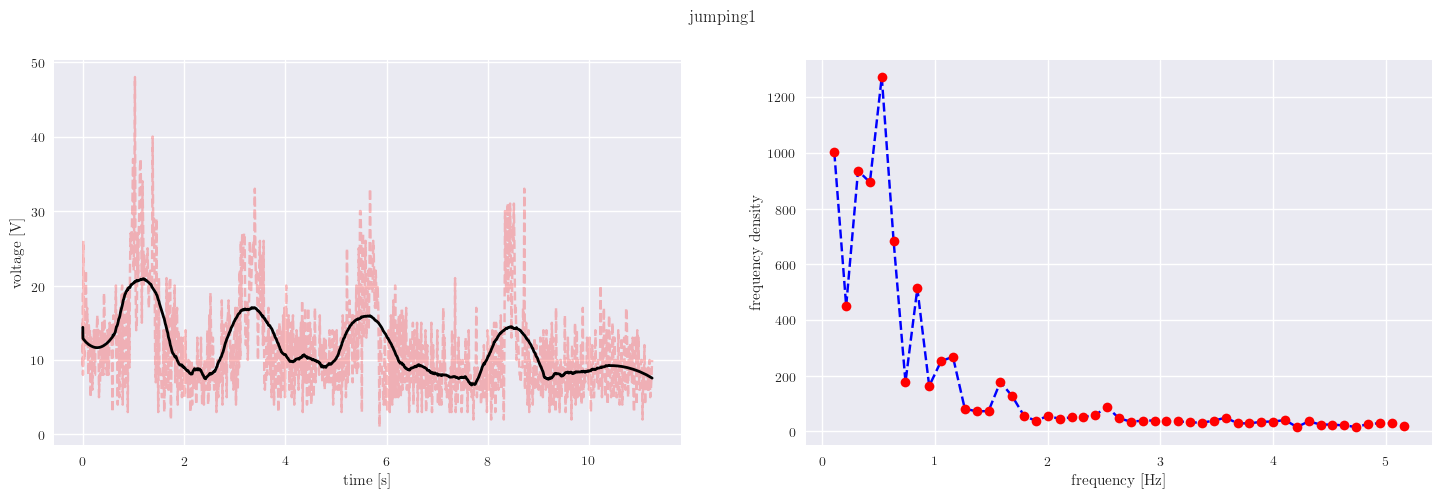

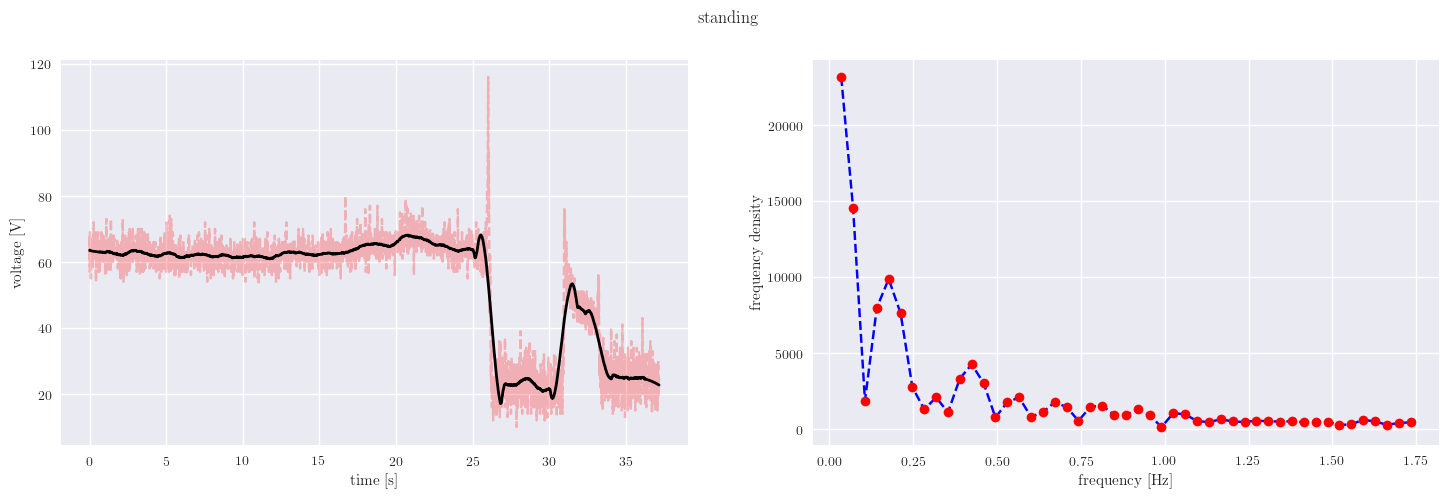

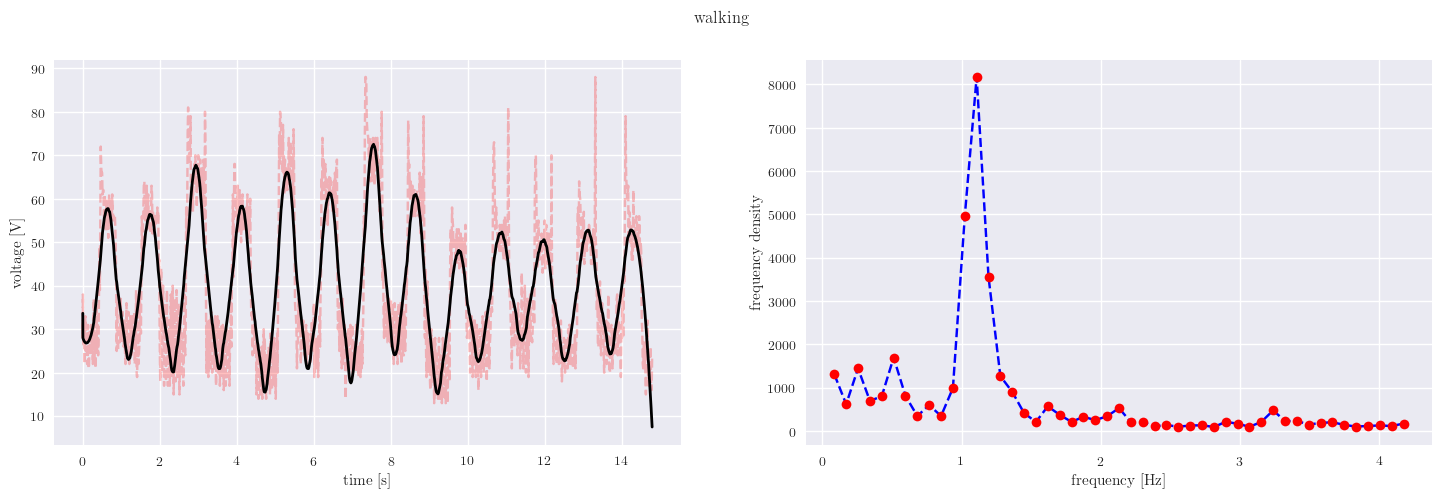

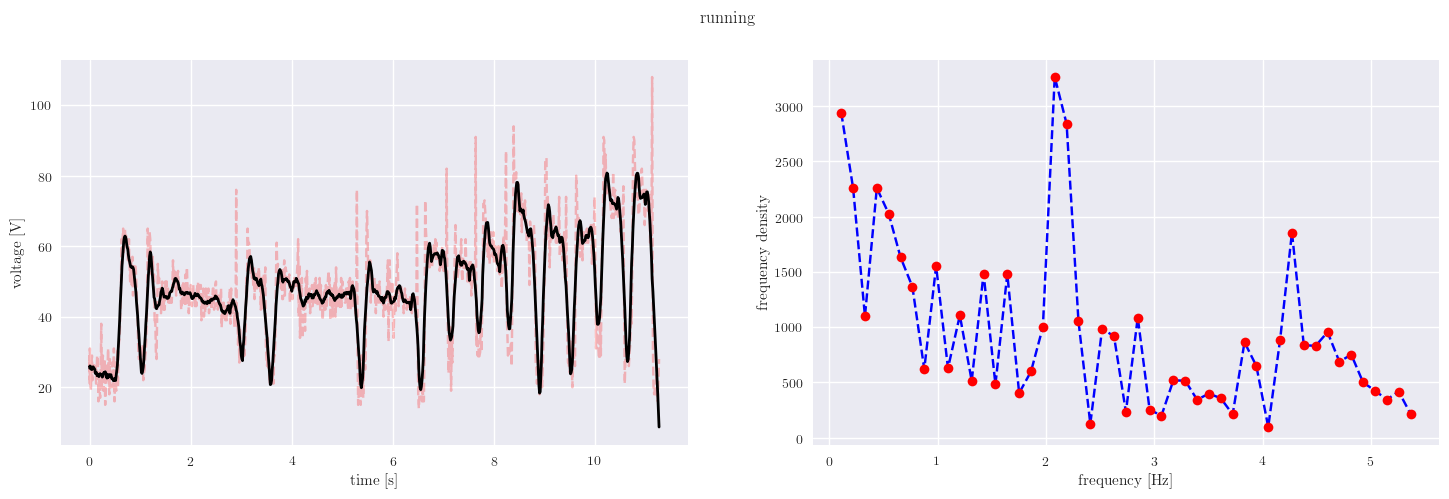

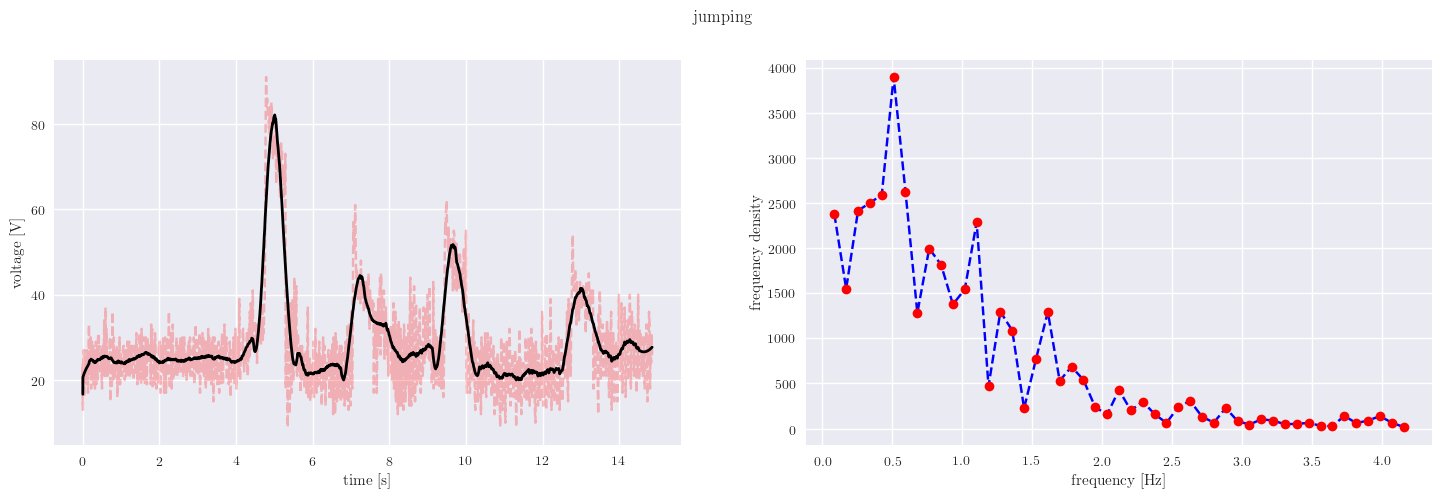

In [14]:
characterization("standing1.log", 131, 2, [1,50])
characterization("walking1.log", 71, 2, [1,50])
characterization("running1.log", 31, 2, [1,50])
characterization("jumping1.log", 131, 2, [1,50])
characterization("standing.log", 131, 2, [1,50])
characterization("walking.log", 71, 2, [1,50])
characterization("running.log", 21, 2, [1,50])
characterization("jumping.log", 51, 2, [1,50])

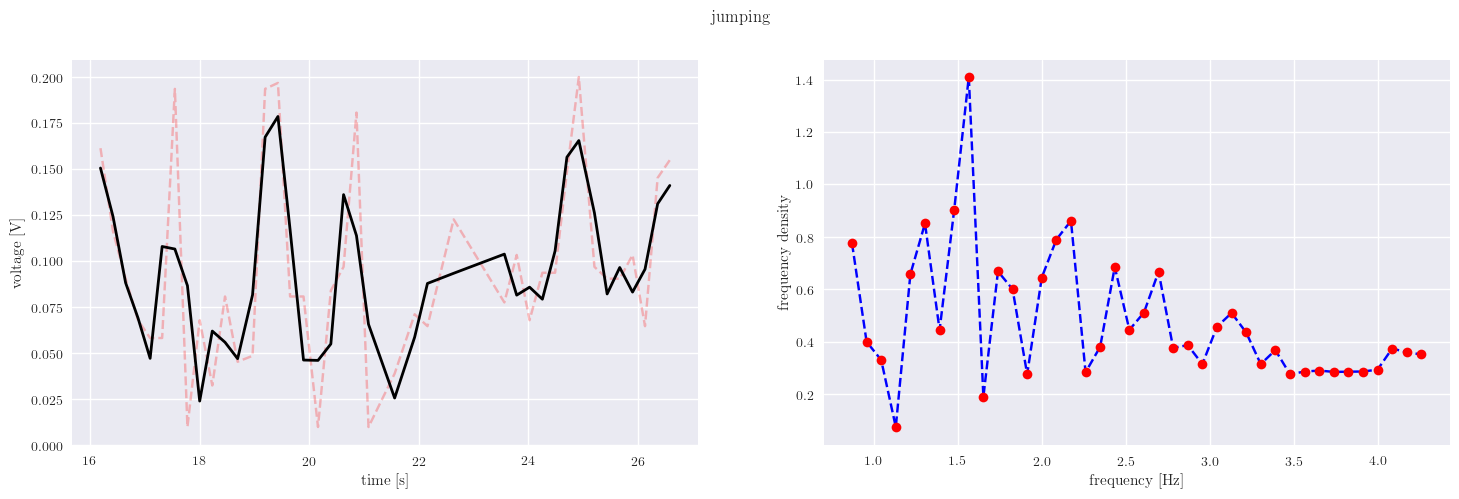

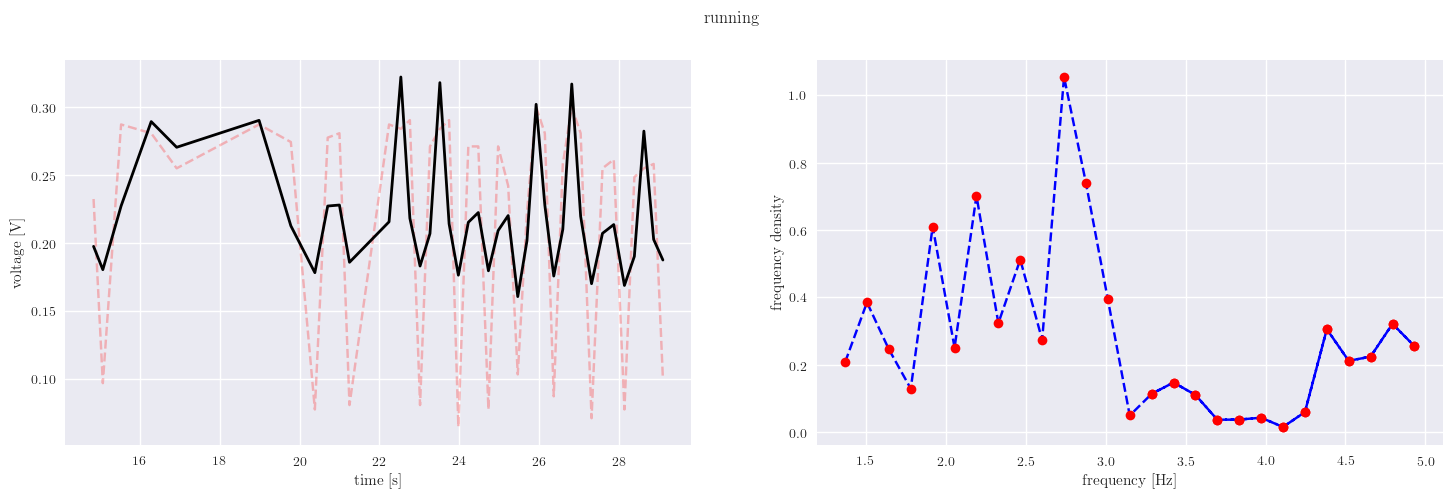

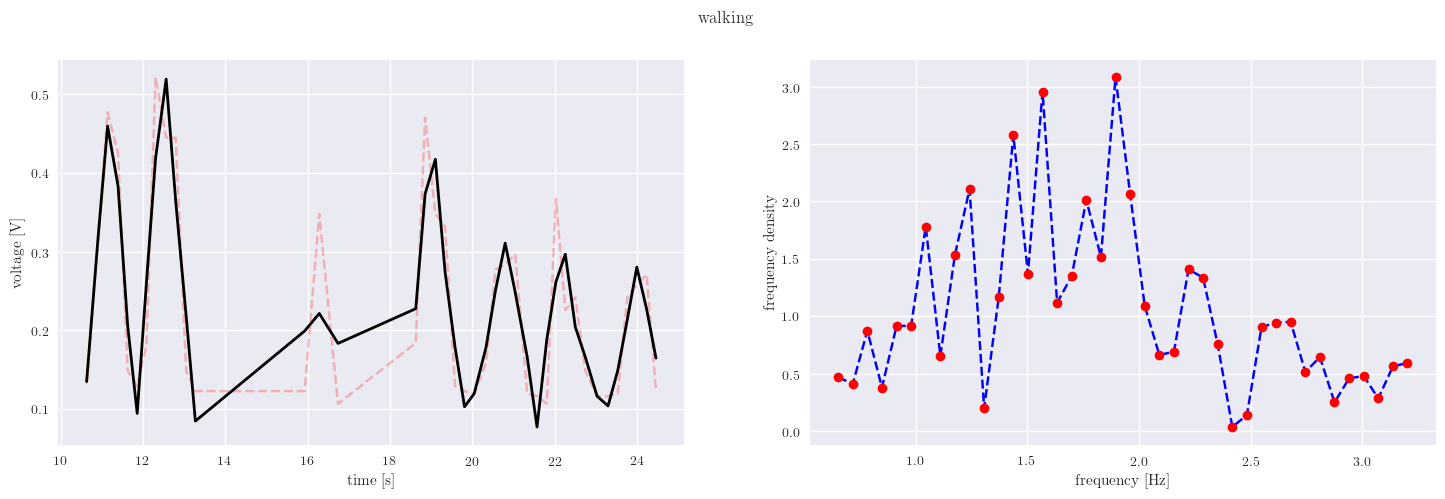

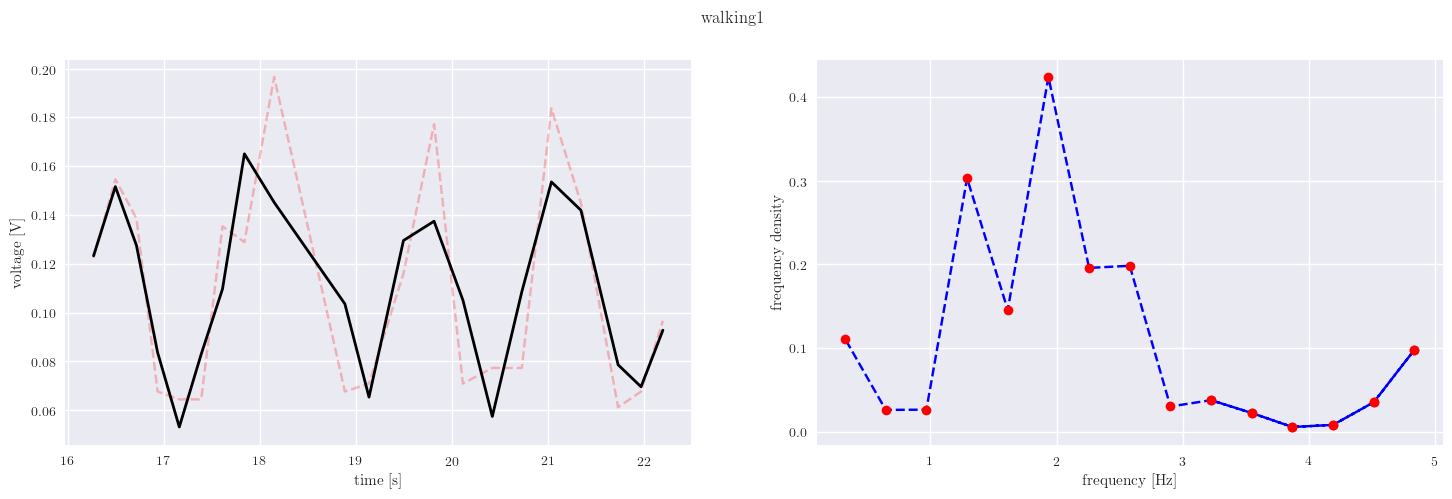

In [20]:
for _, __, files in os.walk("."):
    for file in files:
        if file.endswith(".npy"):
            characterization(file, 5, 2, [10,50], True)